Make all the imports

In [1695]:
from datetime import datetime
from math import log1p
import pandas_datareader as web
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
import warnings

from prompt_toolkit.key_binding.bindings.named_commands import accept_line

warnings.filterwarnings("ignore")
%matplotlib inline

Get all the stock symbols and dowload all the closing prices and the volumes traded from Yahoo Finance

In [1696]:
stocks = []
f = open('symbols.txt', 'r')
for line in f:
    stocks.append(line.strip())
f.close()

#Uncomment the following two lines if you haven't downloaded the stock information before.
#yf.download(stocks, start='2000-01-01', end='2024-09-02')['Adj Close'].to_csv('prices.csv')

Create dataframes containing the log changes in volumes and log changes in price

In [1697]:
prices = pd.read_csv('prices.csv', index_col = 'Date', parse_dates=True)
pricechanges = pd.read_csv('prices.csv', index_col = 'Date', parse_dates=True)
pricechanges = np.log(pricechanges / pricechanges.shift(1))

Set the start and end date of the simulation and all the lists/dictionaries required for the simulation

In [1698]:
today = dt.date(2013,8,29)
simend = dt.date(2014,8,29)
mid_date = today + (simend - today)/2
tickers = []
daily_profit = []
stock_profits = {}
transactionid = 0
money = 1000000
portfolio = {}
activelog = []
transactionlog = []
short_window = 50
long_window = 150
short_ma = prices.rolling(window=short_window).mean()
long_ma = prices.rolling(window=long_window).mean()

Get the current prices of all stocks.

In [1699]:
def getprice(date, ticker):
    global prices
    return prices.loc[np.datetime64(date)][ticker]

Makes two dictionaries of all the transactoins we do:
- The first dictionary is all of our active positions
- The second dictionary contains all transactions that have been made.


In [1700]:
def transaction(trans_id, ticker, amount, price, trans_type):
    global transactionid, transactionlog, today
    if trans_type == 'buy':
        transactionid += 1
        data = {'transaction ID':transactionid, 'ticker':ticker, 'amount':amount, 'price':price, 'type':'buy', 'date':today}
        activelog.append(data)
    if trans_type == 'sell':
        data = {'transaction ID':trans_id, 'ticker':ticker, 'amount':amount, 'price':price, 'type':'sell', 'date':today}
    transactionlog.append(data)

This function buys all of the stocks in our interest list with the allocated money and then calls the transaction function to record the transaction

In [1701]:
def buy(interestlst, allocated_money):
    global money, portfolio
    allocated_money = 20000
    for item in interestlst:
        price = getprice(today, item)
        if not np.isnan(price) and money >= 21000:
            quantity = math.floor(allocated_money/price)
            money -= quantity*price
            portfolio[item] = portfolio[item] + quantity
            transaction(0, item, quantity, price, 'buy')

Sells all the stocks that meet the conditions of our strategy. The transaction() function is called to record the transaction. All the sold stocks are removed from our active log.

In [1702]:
def sell():
    global money, portfolio, prices, today, short_ma, long_ma, daily_profit, stock_profits
    itemstoremove = []
    profit = 0
    for i in range(len(activelog)):
        log = activelog[i]
        ticker = log['ticker']
        original_price = log['price']
        tickprice = getprice(today, ticker)
        
        short_ma_value = short_ma[ticker].loc[today.strftime('%Y-%m-%d')]
        long_ma_value = long_ma[ticker].loc[today.strftime('%Y-%m-%d')]
        
        if ((short_ma_value < long_ma_value) or (0.99 * original_price >= tickprice)) and portfolio[ticker] > 0:
            stock_profits[ticker] = stock_profits[ticker] + (tickprice - original_price) * log['amount']
            profit = (tickprice - original_price) * log['amount']
            money += log["amount"] * tickprice
            portfolio[ticker] -= log["amount"]
            transaction(log["transaction ID"], ticker, log["amount"], tickprice, "sell")
            itemstoremove.append(i)

        elif (1.03 * original_price <= tickprice) or (portfolio[ticker] < 100 and 1.01 * original_price <= tickprice) and portfolio[ticker] > 0:
            stock_profits[ticker] = stock_profits[ticker] + (tickprice - original_price) * log['amount']
            profit += (tickprice - original_price) * log['amount']
            money += log["amount"] * tickprice
            portfolio[ticker] -= log["amount"]
            transaction(log["transaction ID"], ticker, log["amount"], tickprice, "sell")
            itemstoremove.append(i)
        
    daily_profit.append(profit)
    itemstoremove.reverse()
    for elem in itemstoremove:
        activelog.remove(activelog[elem])


Creates a list of all the stocks that are worth buying according to our strategy

In [1703]:
def simulation():
    global today, prices, money, portfolio, pricechanges
    tickers = portfolio.keys()
    interestlst = []
    start_date = today - dt.timedelta(days=7)

    for ticker in tickers:
        short_ma_value = short_ma[ticker].loc[today.strftime('%Y-%m-%d')]
        long_ma_value = long_ma[ticker].loc[today.strftime('%Y-%m-%d')]
        if np.isnan(short_ma_value) or np.isnan(long_ma_value):
            continue
        if short_ma_value > long_ma_value:
            interestlst.append(ticker)
   
    meanprice = pricechanges.loc[start_date:today].mean().sort_values()
    interestlst2 = meanprice[(meanprice > 0.00900)].index.tolist()
    interestlst.extend(interestlst2)
    set(interestlst)
    sell()

    if len(interestlst) > 0:
        moneyToAllocate = money/(2*len(interestlst))
        buy(interestlst[0:round(len(interestlst)/2)], moneyToAllocate)

**getindices():** This function gets all the stock symbols and stores them.

In [1704]:
def getindices():
    global tickers
    f = open("symbols.txt", "r")
    for line in f:
        tickers.append(line.strip())
    f.close()

**tradingday():** This finction checks if today is a trading day and returns a boolean.

In [1705]:
def tradingday():
    global prices, today
    return np.datetime64(today) in list(prices.index.values)

**currentvalue():** This function calculates the total account value (money + the portfolio value).

In [1706]:
def currentvalue():
    global money, portfolio, today, prices
    value = money
    for ticker in tickers:
        tickprice = getprice(today, ticker)
        if not np.isnan(tickprice):
            value += portfolio[ticker]*tickprice
    return int(value*100)/100

**statistics():** This function is used to show some statistics on the simulator

In [1707]:
def statistics():
    global money_list, volume_lst, loss_days, profit_days, accountvalue, dates, portfolio_values, stock_trades, stock_profits
   
    figure, axes1 = plt.subplots(figsize=(20, 6))
    axes1.plot(dates, money_list)
    axes1.set_xlabel("Date")
    axes1.set_ylabel("Cash", color='blue')
    plt.xticks(rotation=90)
    axes2 = axes1.twinx()
    axes2.plot(dates, accountvalue, color='red')
    axes2.set_xlabel("Date")
    axes2.set_ylabel("Account Value", color='red')
    plt.title('Overall Performance')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(20,6))
    plt.plot(dates, daily_profit)
    plt.xlabel("Date")
    plt.ylabel("Profit")
    plt.xticks(rotation=90)
    plt.title('Daily Profit or Loss')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(20,6))
    plt.plot(dates, volume_lst)
    plt.xlabel("Date")
    plt.ylabel("Stock Volume")
    plt.xticks(rotation=90)
    plt.title('Volume of stocks in our portfolio every day')
    plt.grid(True)
    plt.show()
    
    for i in daily_profit:
        if i > 0:
            profit_days += 1
        else:
            loss_days += 1
    plt.bar(['Days with profit', 'Days with loss'], [profit_days,loss_days])
    plt.ylabel('Days')
    plt.grid(True)
    plt.show()
    
    for i in range(len(transactionlog)):
        log = transactionlog[i]
        stock_trades[log ['ticker']] += log ['amount'] 
    stock_trades = dict(sorted(stock_trades.items(), key=lambda item: item[1], reverse=True))
    stock_trades = dict(list(stock_trades.items())[:10])
    stock_profits = dict(sorted(stock_profits.items(), key=lambda item: item[1], reverse=True))
    stock_profits = dict(list(stock_profits.items())[:10])
    
    figure, axes1 = plt.subplots(figsize=(20, 6))
    axes1.bar(stock_profits.keys(), stock_profits.values())
    axes1.set_xlabel("Stocks")
    axes1.set_ylabel("Profit")
    axes1.set_title('Ten Most Profitable Stocks')
    axes1.grid(True)
        
    fig, (axes1,axes2) = plt.subplots(1,2,figsize=(12,20))
    axes1.barh(portfolio_values.keys(), portfolio_values.values())
    axes1.set_ylabel("Stocks")
    axes1.set_xlabel("Total Value")
    axes1.set_title('Final Portfolio')
    axes1.grid(True)
    
    axes2.barh(stock_trades.keys(), stock_trades.values())
    axes2.set_ylabel("Stocks")
    axes2.set_xlabel("Volume Traded")
    axes2.set_title('Ten most traded stocks')
    axes2.grid(True)
    plt.tight_layout()
    plt.show()

The main function resets the protfolio and iterates through all the dates, calling the simulation function in order to buy and sell according to our strategy.

In [1708]:
def main():
    global today, money, portfolio, daily_profit
    global money_list, volume_lst, loss_days, profit_days, accountvalue, dates, mid_date, portfolio_values, stock_trades
    getindices()
    stock_trades = {}
    for ticker in tickers:
        portfolio[ticker] = 0
        stock_trades[ticker] = 0
        stock_profits[ticker] = 0
    profit_days = 0
    loss_days = 0
    volume_lst = []
    dates = []
    money_list = []
    accountvalue = []
    while today < simend:
        while not tradingday():
            today += dt.timedelta(days=1)
        simulation()
        currentpvalue = currentvalue()
        today += dt.timedelta(days=1)
        accountvalue.append(currentpvalue)
        dates.append(today)
        money_list.append(money)
        stock_volume = sum(portfolio.values())
        volume_lst.append(stock_volume)
    portfolio_values = {}
    for stock in portfolio.keys():
        if portfolio[stock] > 0:
            portfolio_values[stock] = portfolio[stock] * getprice(today, stock)
    statistics()
        
   
    

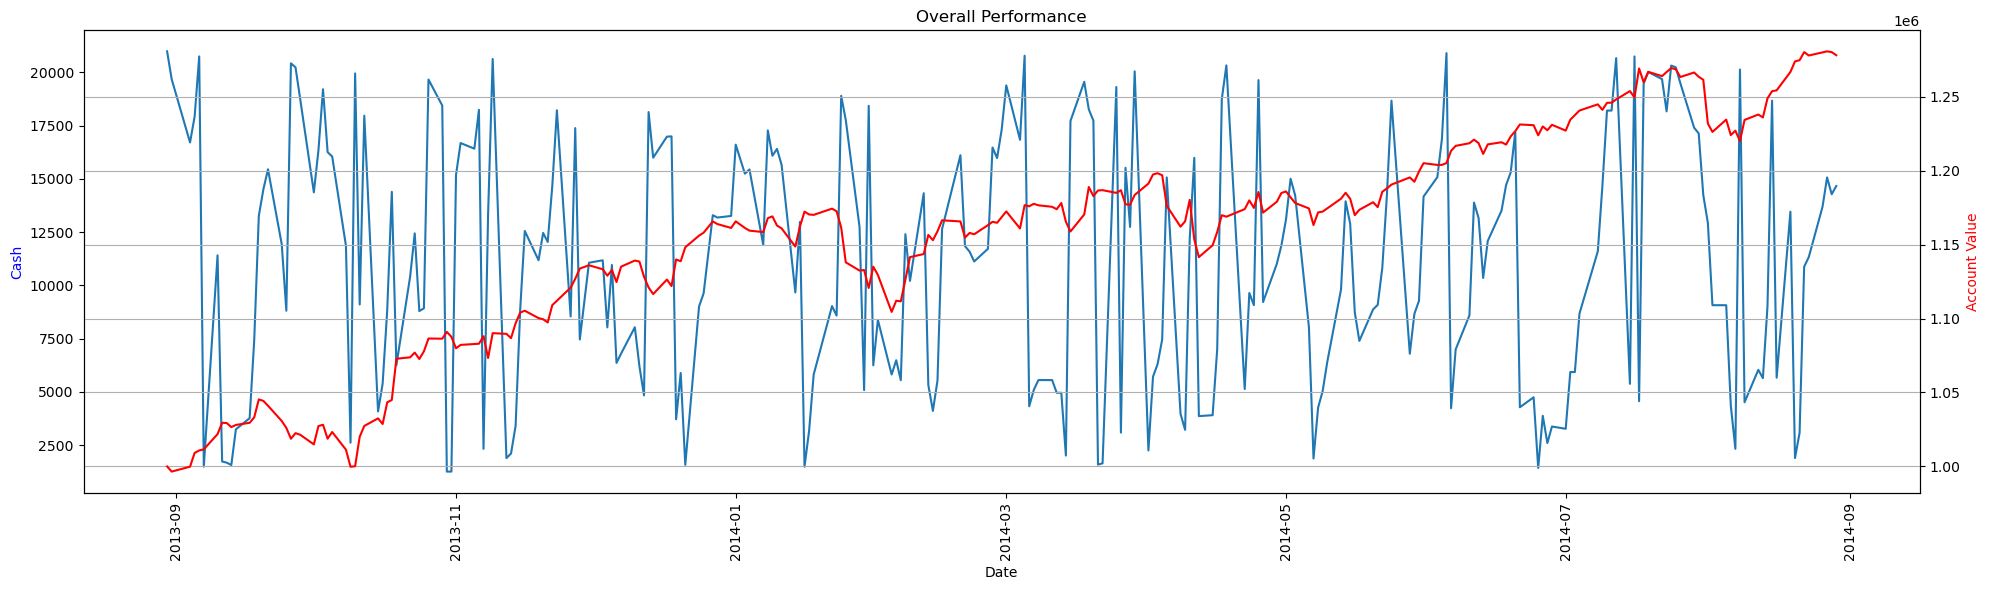

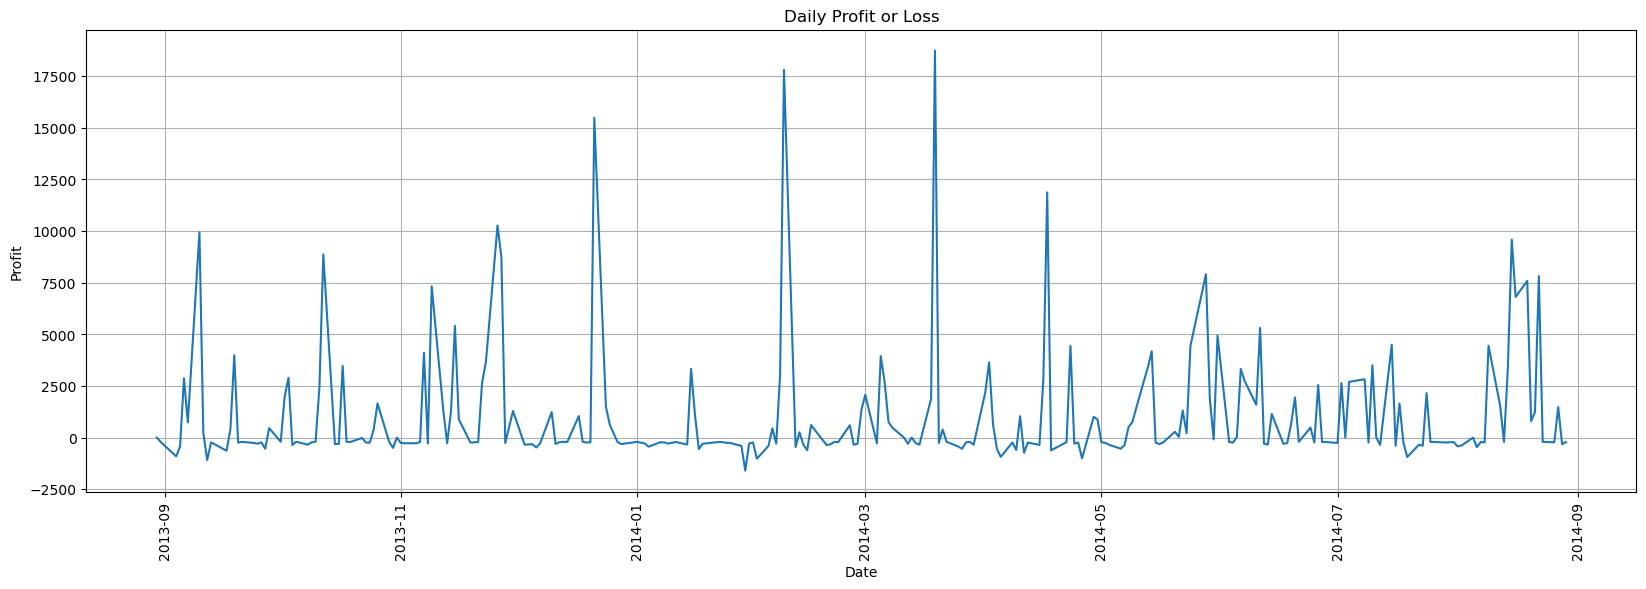

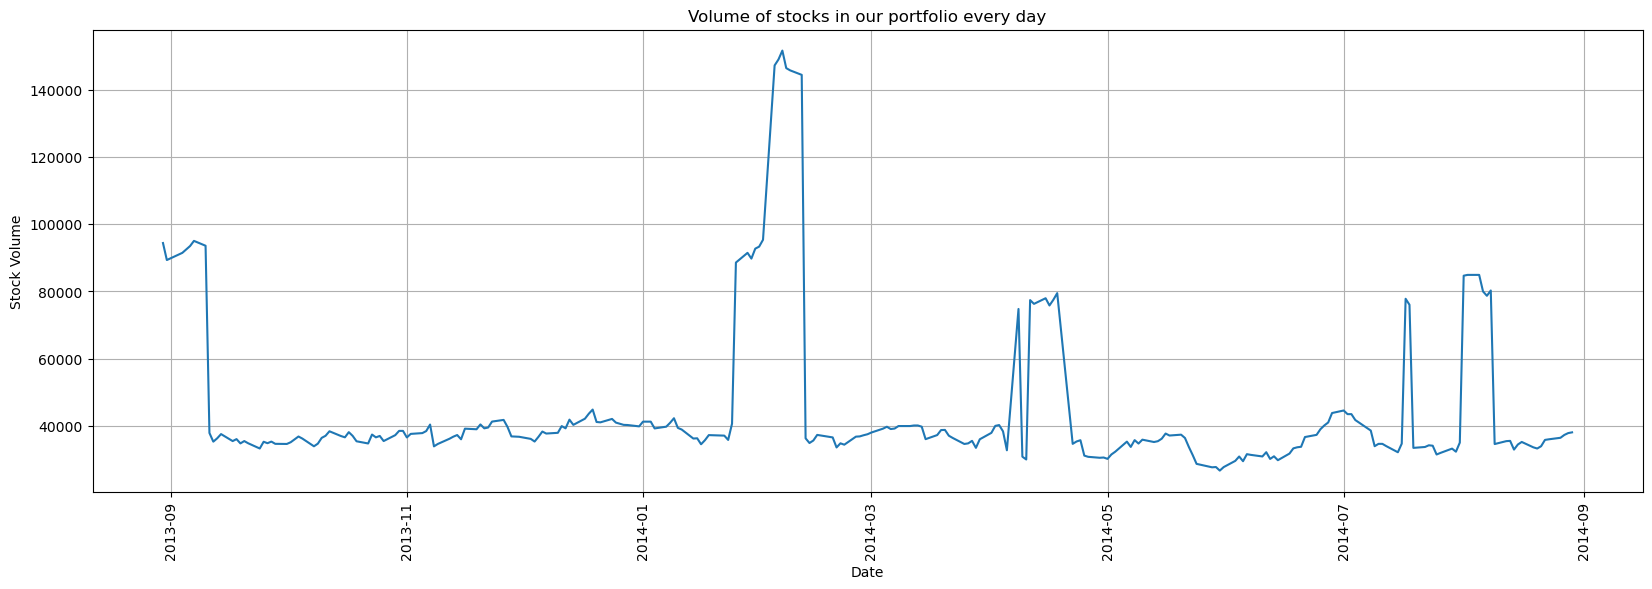

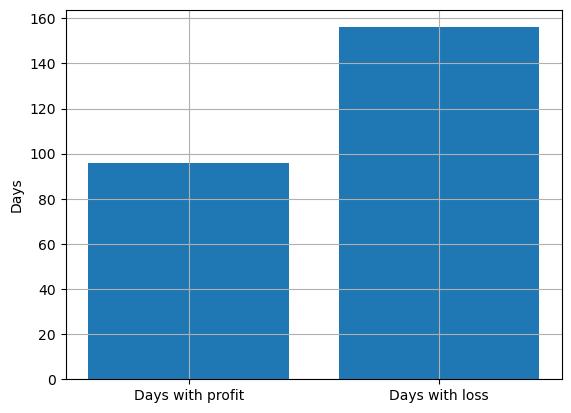

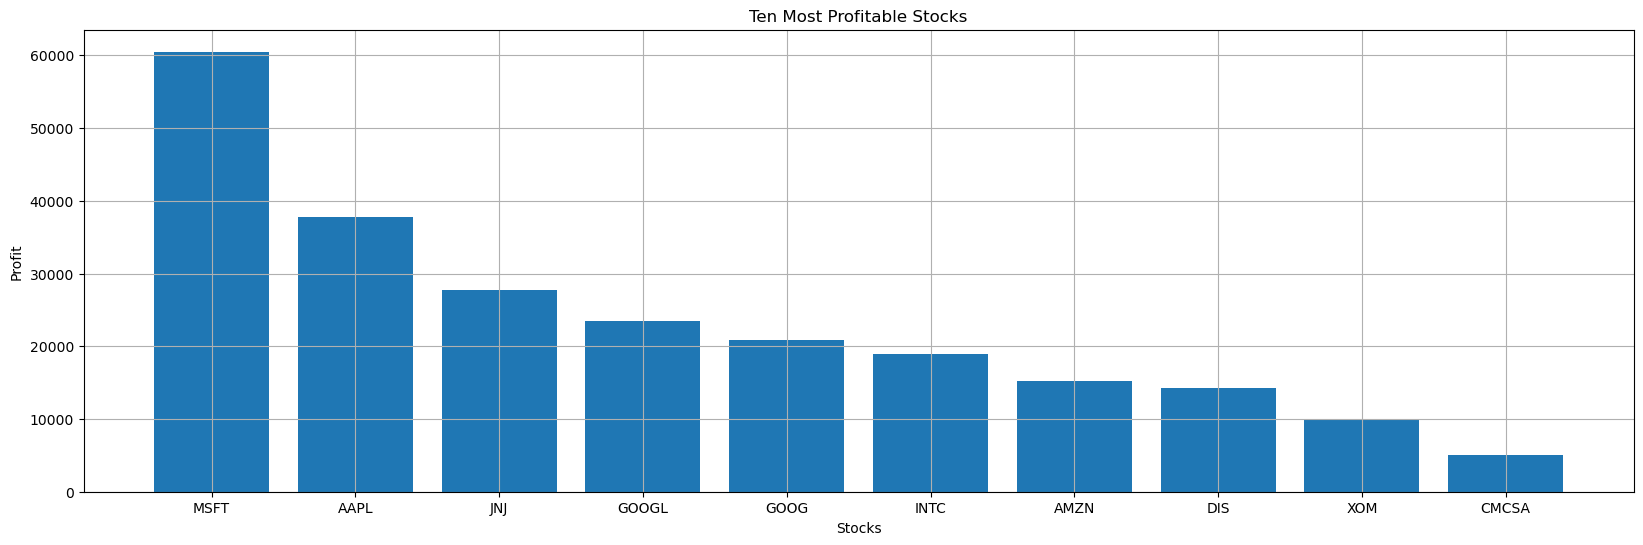

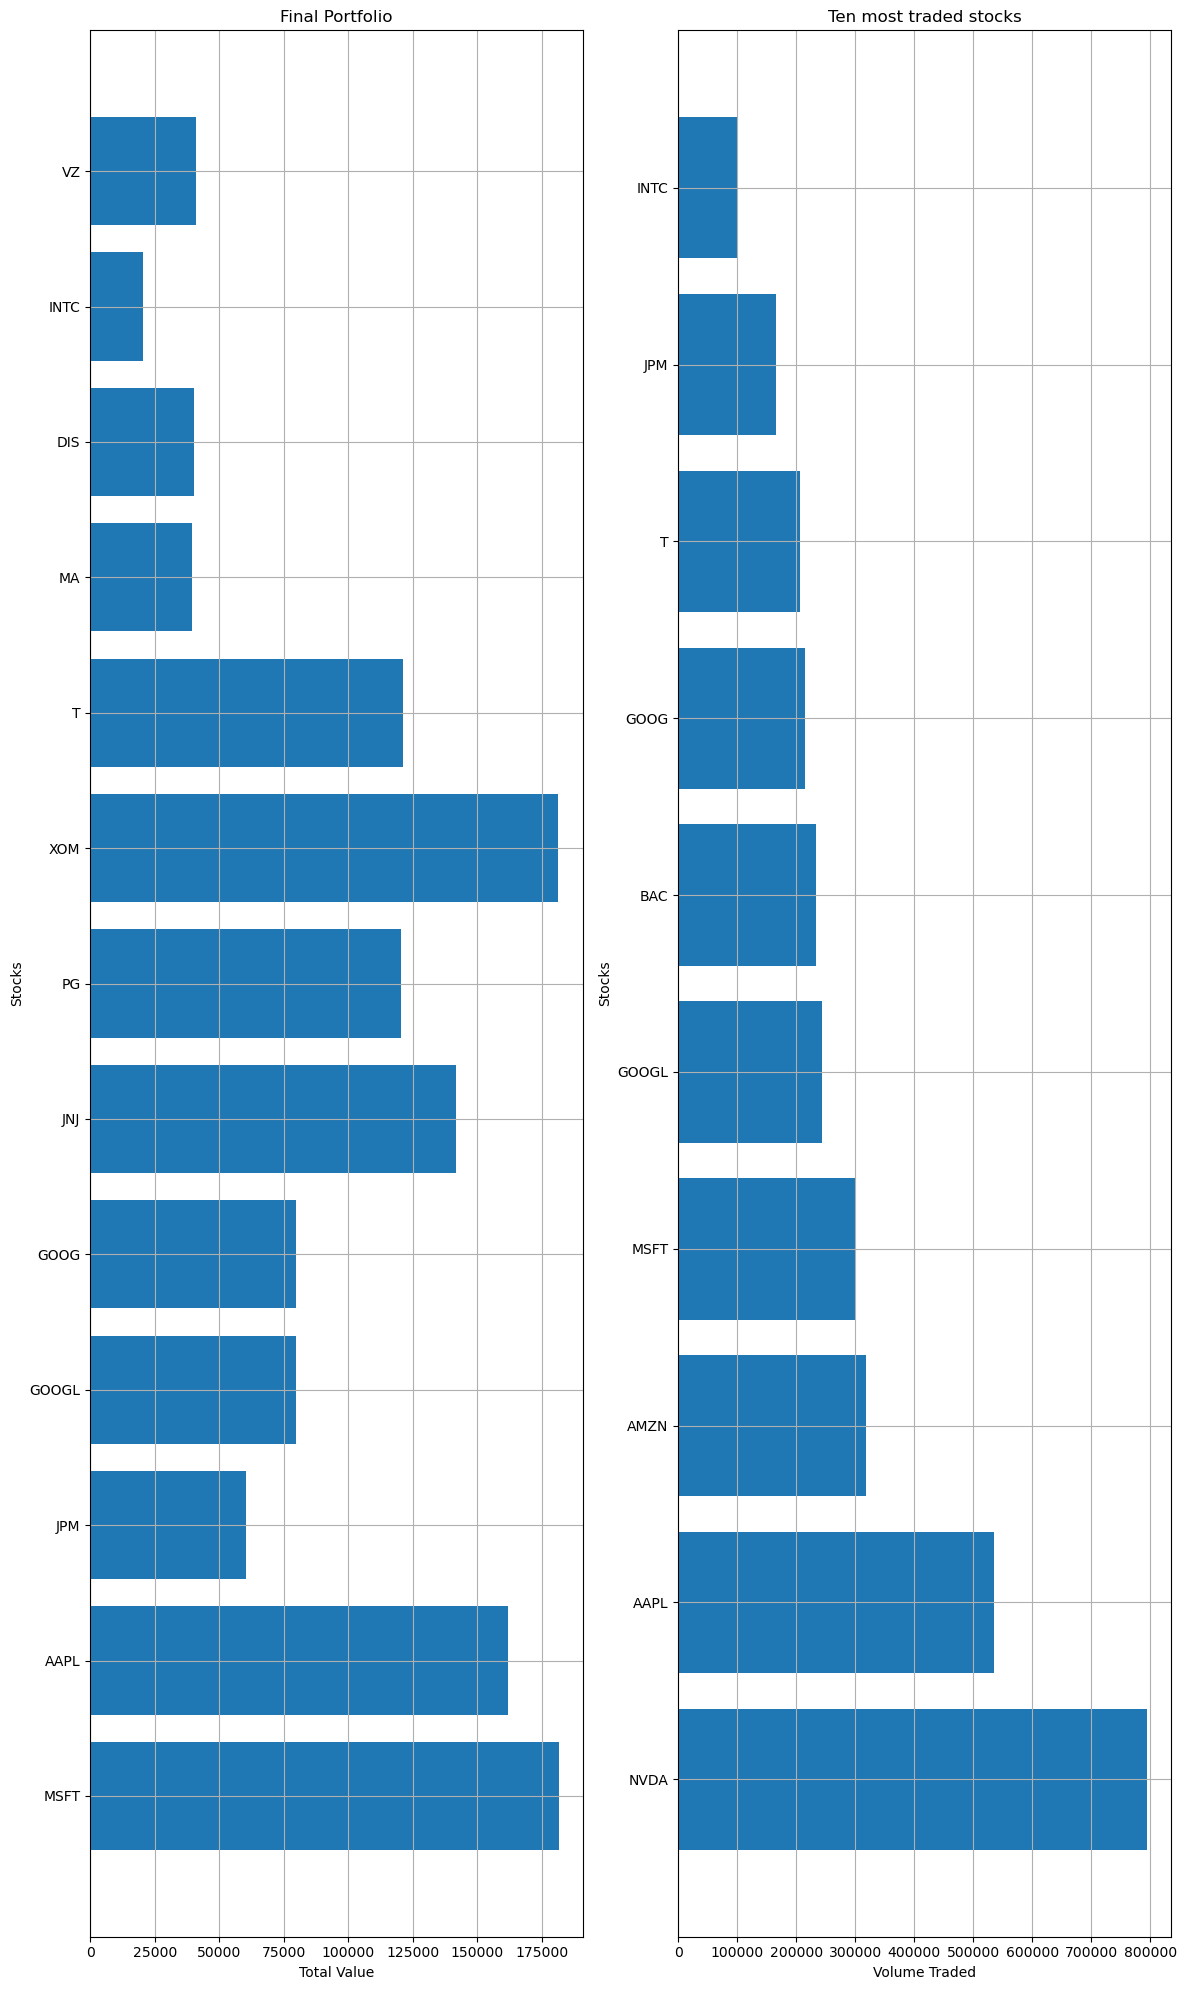

In [1709]:
main()